In [4]:
"""AlexNet feature extractor.
Extracts features from an image, using an AlexNet model.
"""
import argparse

import caffe
import matplotlib.pyplot as plt
import numpy as np

from env.env import *

caffe.set_mode_gpu()

image_path = research_root + 'images/bulls/bull2.jpg'
alexnet_model = 'bvlc_reference_caffenet.caffemodel'


def visualize_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])

    plt.imshow(data)
    plt.show()


plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

net = caffe.Net(original_models_root + 'bvlc_reference_caffenet/deploy.prototxt',
                original_models_root + 'bvlc_reference_caffenet/' + alexnet_model,
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.load(ilsvrc_mean_file_path).mean(1).mean(1))
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2, 1, 0))
net.blobs['data'].reshape(50, 3, 227, 227)

net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(image_path))
out = net.forward()

print("Predicted class is #{}.".format(out['prob'][0].argmax()))

Predicted class is #347.


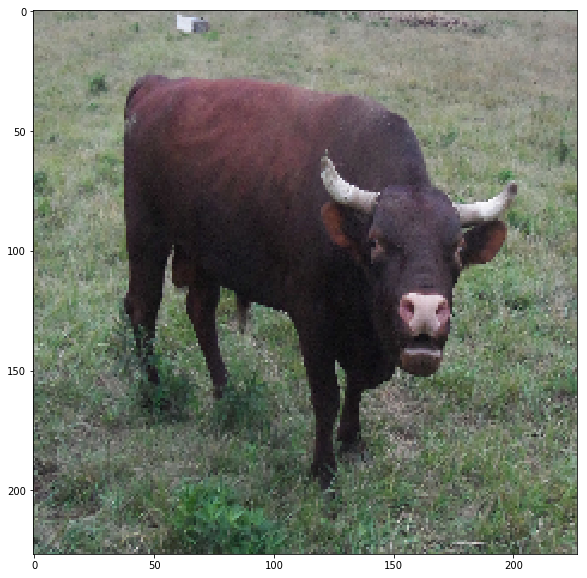

In [5]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))
plt.show()

In [6]:
imagenet_labels_filename = dataset_root + 'ilsvrc12/synset_words.txt'
labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print labels[top_k]

['n02410509 bison'
 'n02408429 water buffalo, water ox, Asiatic buffalo, Bubalus bubalis'
 'n02403003 ox' 'n02395406 hog, pig, grunter, squealer, Sus scrofa'
 'n02397096 warthog']


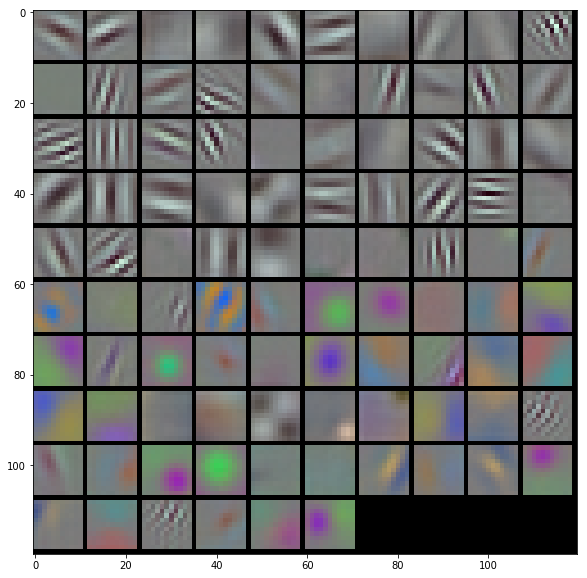

In [7]:
filters = net.params['conv1'][0].data
visualize_square(filters.transpose(0, 2, 3, 1))

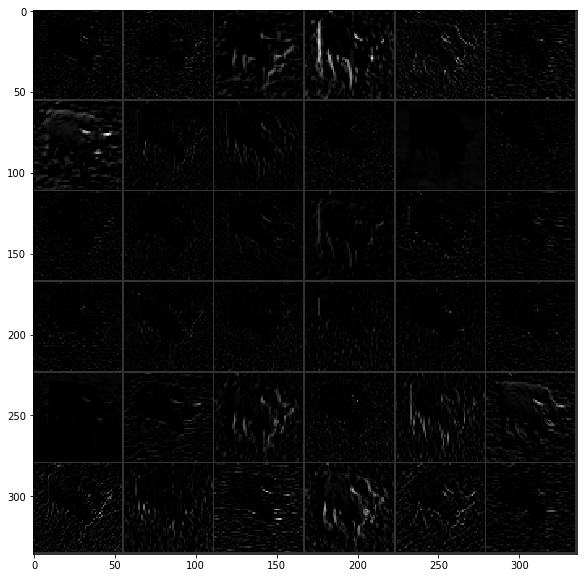

In [8]:
feat = net.blobs['conv1'].data[0, :36]
visualize_square(feat, padval=0.2)

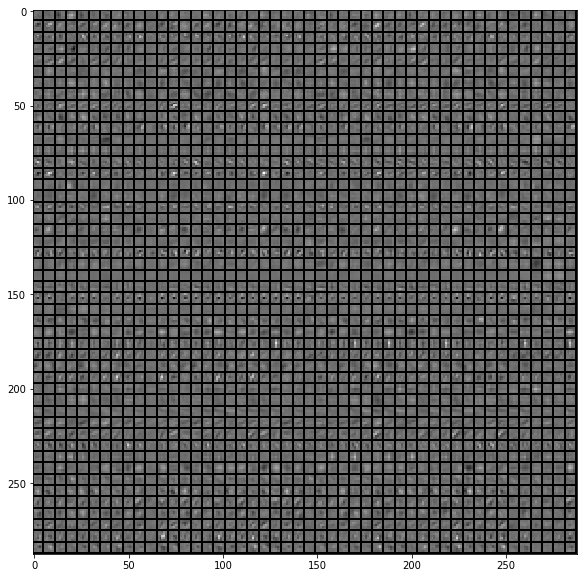

In [9]:
filters = net.params['conv2'][0].data
visualize_square(filters[:48].reshape(48**2, 5, 5))

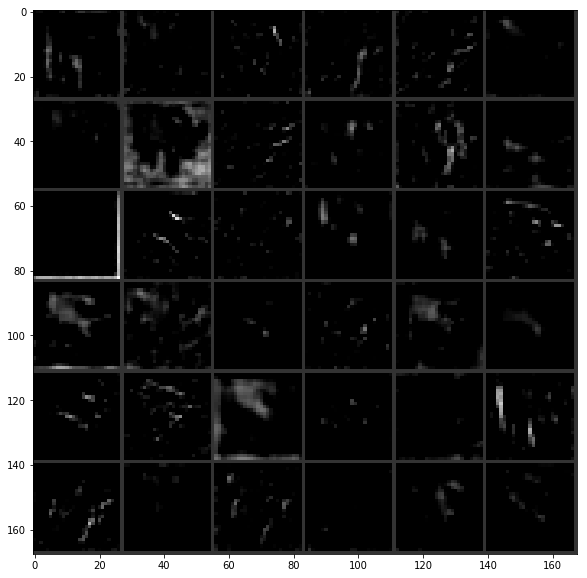

In [10]:
feat = net.blobs['conv2'].data[0, :36]
visualize_square(feat, padval=0.2)

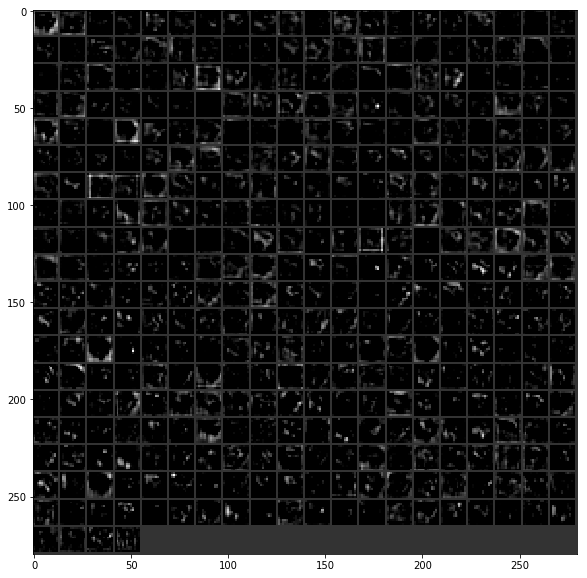

In [11]:
feat = net.blobs['conv4'].data[0]
visualize_square(feat, padval=0.2)

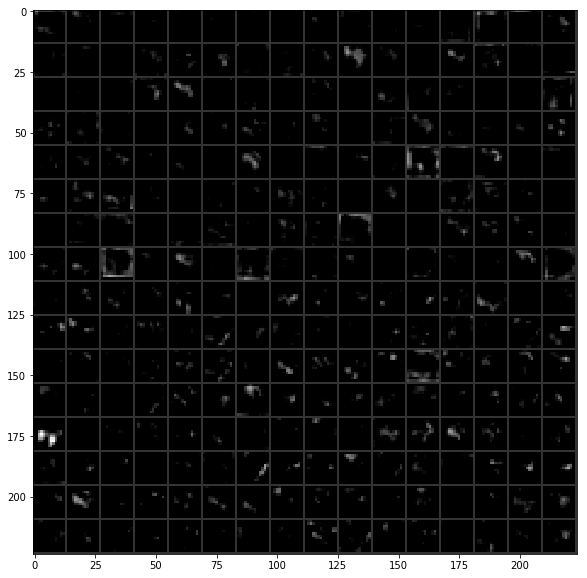

In [12]:
feat = net.blobs['conv5'].data[0]
visualize_square(feat, padval=0.2)

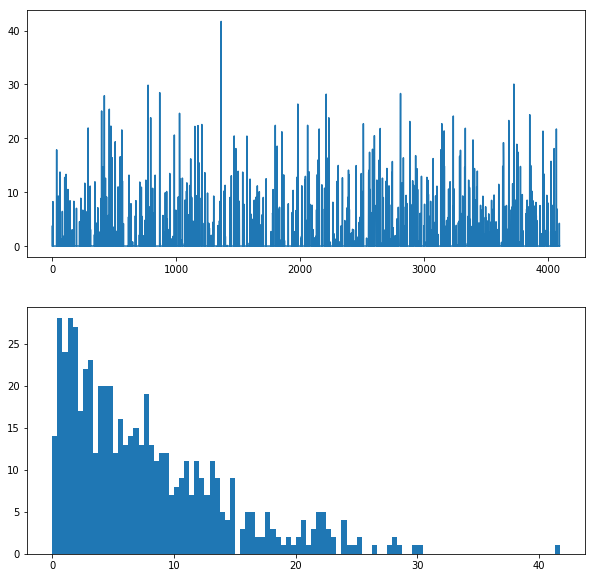

In [13]:
# Rectified fc6
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

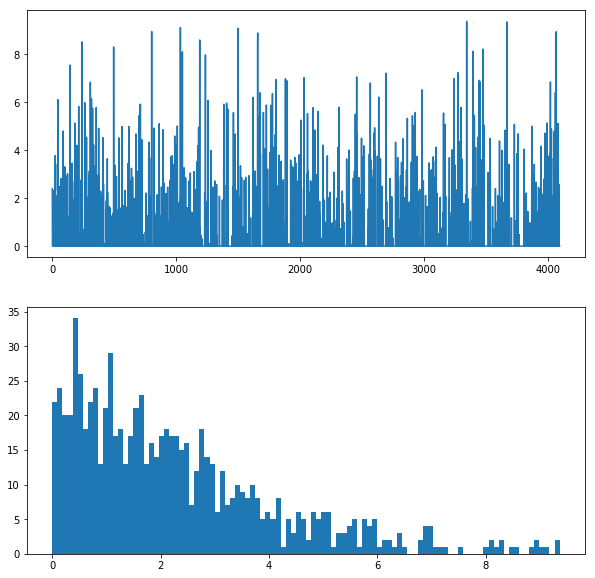

In [14]:
# Rectified fc7
feat = net.blobs['fc7'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

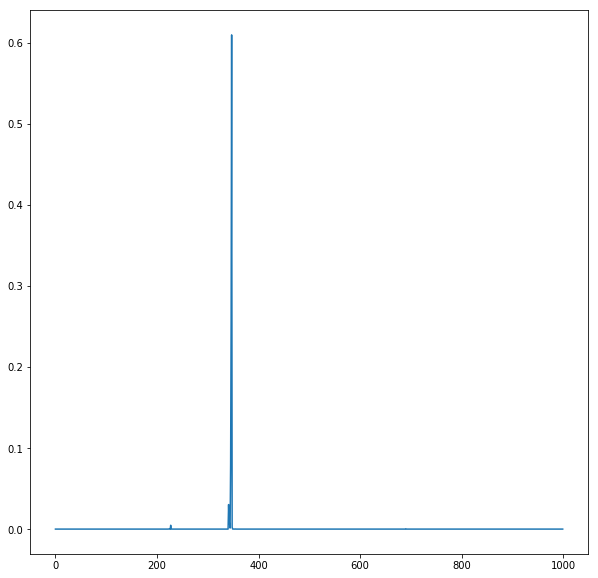

In [15]:
# Last layer output
feat = net.blobs['prob'].data[0]
plt.plot(feat.flat)